# Introduction

We explore random variable transformation implementation using Tensorflow in this notebook. Random variable transformation is useful when we want to construct probability density. Moreover sometimes, we want to approximate a target distribution $p$ whose support is constrained with an approximiate distribution $q$. We can build an approximiate distribution $q^\prime$ with unconstrained support and then transform it into $q$ .

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
plt.rcParams['figure.figsize'] = (20,10)

In [44]:
sess = tf.Session()

# Bijectors

This is used to transform random variable into another variable, ``TransformedDistribution``. But generally, it can be generally used to transform a distribution-generated Tensor. There are three operations that characterized by three operations:

1. Forward
2. Inverse
3. log_det_jacobian

### Exponential Transformation

$$\begin{align}
y &=g(X) = exp(X)\\
X &\sim Normal(0,1)
\end{align}$$

With the exponential transform: 

$$
Y \sim LogNormal(0,1)
$$

In [23]:
N = 5000

In [25]:
x_ = tfd.Normal(loc=0., scale=1.).sample(N)
y_ = tf.exp(x_)

In [26]:
direct_y_ = tfd.LogNormal(loc=0., scale=1.).sample(N)

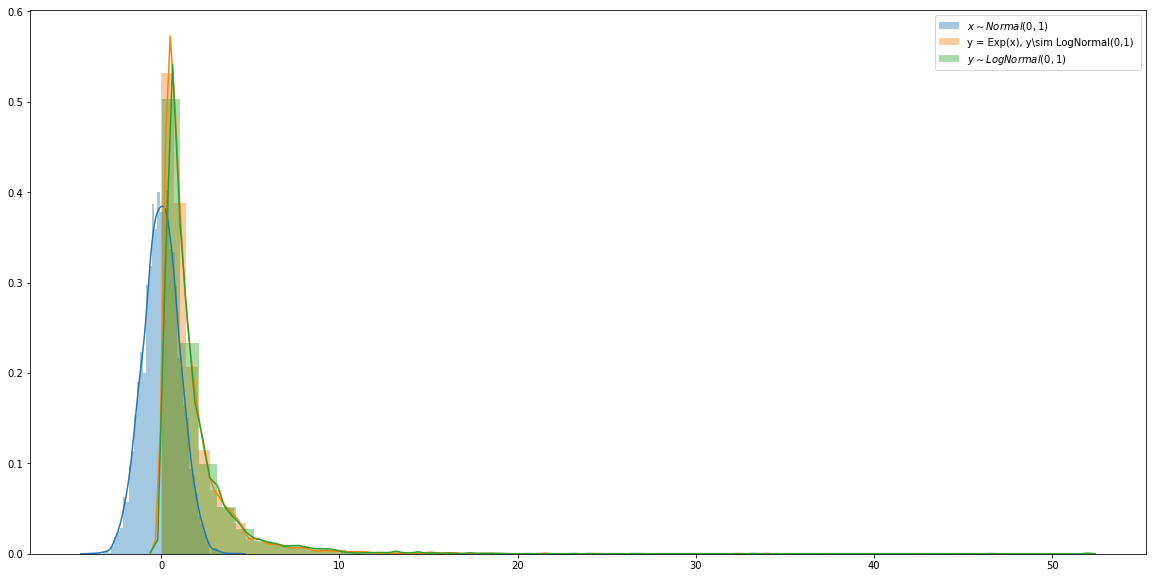

In [33]:
sns.distplot(sess.run(x_), label='$x \sim Normal(0,1)$')
sns.distplot(sess.run(y_), label= 'y = Exp(x), y\sim LogNormal(0,1) ')
sns.distplot(sess.run(direct_y_), label= '$y \sim LogNormal(0,1)$')
plt.legend();

The cdf of Y can be computed mathematically as follows.

$$\begin{align}
f_Y(y) = f_X(g^{-1}(y) \big|\frac{d}{dy}g^{-1}(y)\big|
\end{align}
$$

In the case of the exponential transformation $exp: X \rightarrow Y$, we have the cdf of Y is 

$$f_Y(y) = \frac{1}{y}Normal(log(y);0,1)$$

This transformation of distribution is implemented in tensorflow probability as folows:

In [34]:
class Exp(tfb.Bijector):
    """This class implement the exponetial transformation g: X->Y where X ~ Normal(0,1).
    """
    
    def __init__(self, validate_args=False, name="exp"):
        super(Exp, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=0,
            name=name)
        
    def _forward(self, x):
        """Turn normal samples into log-normal samples
        """
        return tf.exp(x)
    
    def _inverse(self, y):
        """Turn log-normal samples into normal samples
        """
        return tf.log(y)
    
    def _inverse_log_det_jacobian(self, y):
        """Compute log(determinant(d\dy(g^-1 (y))))
        """
        return -self._forward_log_det_jacobian(self._inverse(y))

    def _forward_log_det_jacobian(self, x):
        """ Compute log(determinant(d\dx g(x)))
        
        Notice that we needn't do any reducing, even when`event_ndims > 0`.
        The base Bijector class will handle reducing for us; it knows how
        to do so because we called `super` `__init__` with
        `forward_min_event_ndims = 0`.
        """
        return x

Now let's use our `Exp` bijector to implement the exponetial transformation.

In [35]:
loc = 10.
scale = 1.
N = 1000

In [40]:
y_dist = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=loc, scale=scale),
    bijector=Exp())

In [41]:
y_ = y_dist.sample(N)
direct_y_ = tfd.LogNormal(loc=loc, scale=scale).sample(N)

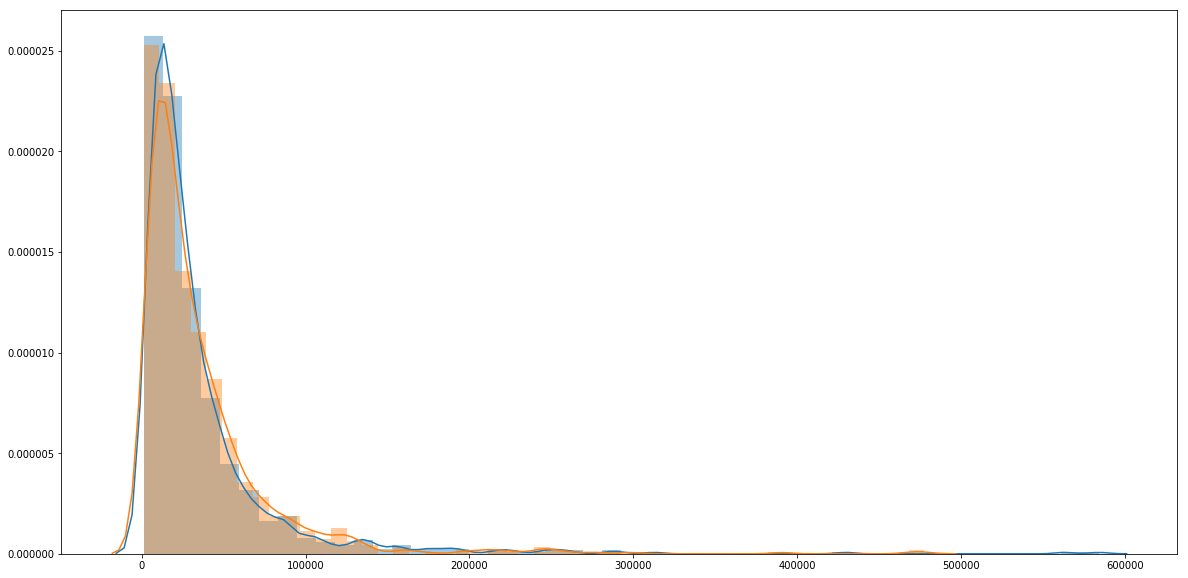

In [45]:
sns.distplot(sess.run(y_), label='transformed distribution')
sns.distplot(sess.run(direct_y_), label='direct samples from LogNormal(0,1)')

That is we have create a LogNormal distribution using `tfd.TransformedDistribution`

In [48]:
y_dist_tf = tfd.TransformedDistribution(distribution=tfd.Normal(loc=loc, scale=scale),
                                       bijector=tfb.Exp())

In [49]:
y_dist_tf_ = y_dist_tf.sample(N)

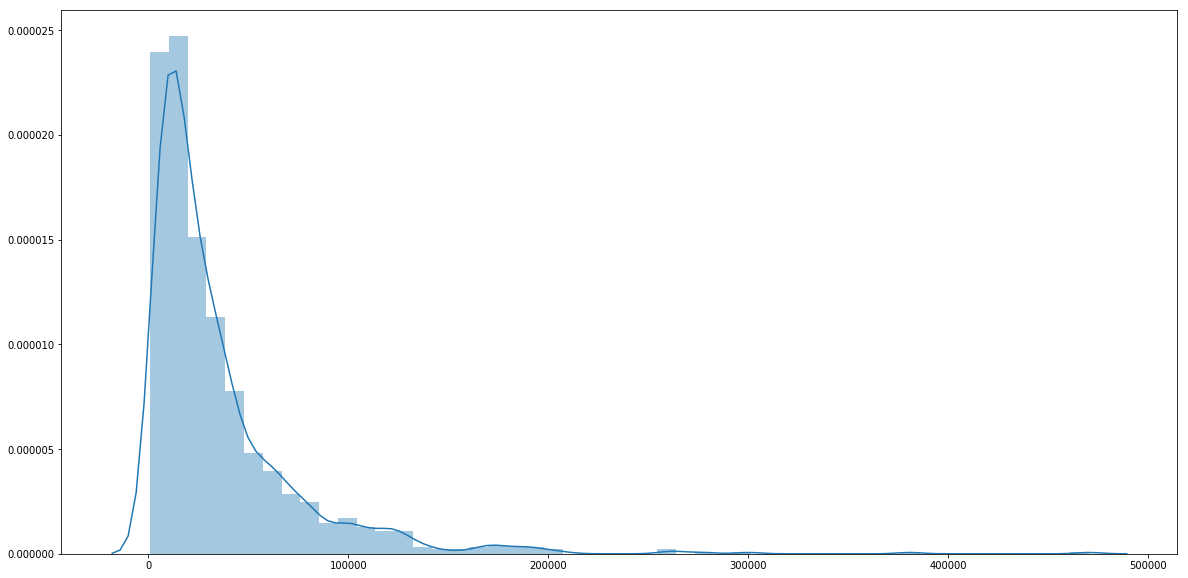

In [50]:
sns.distplot(sess.run(y_dist_tf_))

# Appendix

### Shape Semantics

Let's estimate

$$p(x|\sigma,\mu_0,\sigma_0) = \int_{R}Normal(x|\mu,\sigma)Laplace(\mu|\mu_0, \sigma_0)d\mu$$

In [6]:
mu0 = 10.
sigma0=3.
sigma = 4.
N = 1000

We draw 1000 iid samples of mu from a Laplace distributions

In [7]:
mu = tfd.Laplace(loc=mu0, scale=sigma0).sample(N)

In [8]:
x = [3.]

Then we compute the probability of x according a normal distribution parameterized by $\mu$

In [9]:
pr_x_given_mu = tfd.Normal(loc=mu, scale=sigma).prob(x)

In [10]:
pr_x = tf.reduce_mean(pr_x_given_mu, axis=0)

In [11]:
with tf.Session() as sess:
    print(sess.run(pr_x))

0.028554542
